<a href="https://colab.research.google.com/github/RacingAI/Perception-Workshop/blob/main/fsoco_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cone Detection using PyTorch

Hello Everyone!

Today we will be going through how to make a traffic cone detector using [PyTorch](https://pytorch.org/).

This notebook was adapted from the one in [Fine-tuning Faster-RCNN using pytorch](https://www.kaggle.com/yerramvarun/fine-tuning-faster-rcnn-using-pytorch/notebook)


# Installs and Imports

Install and import PyTorch along with a few helper libraries

Let's install some dependencies and clone the [TorchVision Repo](https://github.com/pytorch/vision) so we can use some helper files

In [ ]:
# Install dependencies and
!pip install albumentations==0.4.6
!pip install pycocotools==2.0.6
!pip install pandas==1.3.5 # todo make these versions explicit. Can probs do them in one line too
!pip install torch==1.13.1+cu116
!pip install torchvision==0.14.1+cu116

# Clone TorchVision repo and copy helper files
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0
%cd ..
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Lets import the libraries

In [ ]:
# basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd

# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# helper libraries
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


# The Dataset

Having a good dataset is essential to training an accurate model. However, just possessing the dataset is not enough. We must pre-process it so that it can be fed to the neural network - and then understood by it.

Finding an existing dataset can sometimes be very difficult. When searching for your dataset you may run into the following problems:

* **Broken links**: even if someone has open-sourced something, links they previously had to their datasets often end up becoming stale.
* **Poor Open-Source Practice**: some "open-source" dataset providers will insist on you contributing to the dataset to be provided access.

However, keep searching! Here's some tricks:

* **Search specific websites**: When searching on Google, you can search specifically on GitHub by searching something like: `cone detection dataset site:github.com`.
* **Reading other people's code**: Try to find the code of someone else that worked on a similar problem, and see if you can find out what dataset they used! Such as searching: `image classification on traffic cones` and trying to find other notebooks.


Luckily the [FSOCO dataset](https://www.fsoco-dataset.com/) was recently made fully public. This includes 24GB of labelled bounding box data for coloured cones. Downloading and training on all 24GB would take a while, so we'll use a 1GB sample for this notebook.

Let's download it!

In [ ]:
%pip install gdown==4.6.0
!gdown https://drive.google.com/uc?id=1Ry_zQri4qKfbBWjGTUG2vhev_VVUjgNi
!unzip fsoco-data-sample.zip

To recreate this sample of the data from scratch, you could use the instructions in this code cell:

In [ ]:
# Download Bounding Boxes dataset from https://www.fsoco-dataset.com/download
# You should then have a fsoco_bounding_boxes_train.zip file

# install fsoco-tools for converting the data format
#!git clone https://github.com/fsoco/fsoco-dataset.git
#%cd fsoco-dataset/tools
#%pip install .[sly]

# use the AMZ data for training
#!unzip fsoco_bounding_boxes_train.zip amz/* -d /content/training-data-sly
#!python click_fsoco.py label-converters sly2yolo /content/training-data-sly /content/training-data
#!rm -rf /content/training-data-sly

# use the EUFS data for testing
#!unzip fsoco_bounding_boxes_train.zip eufs/* -d /content/test-data-sly
#!python click_fsoco.py label-converters sly2yolo /content/test-data-sly /content/test-data
#!rm -rf /content/test-data-sly

#%cd /content

In [ ]:
# we create a Dataset class which has a __getitem__ function and a __len__ function
class ConeImagesDataset(torch.utils.data.Dataset):

  def __init__(self, files_dir, width, height, transforms=None):
    self.images_dir = 'images'
    self.annotations_dir = 'labels'
    self.transforms = transforms
    self.files_dir = files_dir
    self.height = height
    self.width = width

    # sorting the images for consistency
    # To get images, the extension of the filename is checked to be jpg
    self.imgs = [image for image in sorted(os.listdir(os.path.join(files_dir, self.images_dir)))]

    # classes: 0 index is reserved for background
    self.classes = [_, 'yellow_cone', 'blue_cone', 'orange_cone', 'large_orange_cone', 'unknown_cone']

  def __getitem__(self, idx):
    img_name = self.imgs[idx]
    image_path = os.path.join(self.files_dir, self.images_dir, img_name)

    # reading the images and converting them to correct size and color
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
    # diving by 255
    img_res /= 255.0

    # annotation file
    annot_filename = img_name + '.txt'
    annot_file_path = os.path.join(self.files_dir, self.annotations_dir, annot_filename)

    boxes = []
    labels = []

    # cv2 image gives size as height x width
    wt = img.shape[1]
    ht = img.shape[0]

    # box coordinates for xml files are extracted and corrected for image size given
    with open(annot_file_path) as f:
      for line in f:
        parsed = [float(x) for x in line.split(' ')]
        labels.append(parsed[0]+1)
        x_center = parsed[1]
        y_center = parsed[2]
        box_wt = parsed[3]
        box_ht = parsed[4]

        xmin = x_center - box_wt/2
        xmax = x_center + box_wt/2
        ymin = y_center - box_ht/2
        ymax = y_center + box_ht/2

        xmin_corr = int(xmin*self.width)
        xmax_corr = int(xmax*self.width)
        ymin_corr = int(ymin*self.height)
        ymax_corr = int(ymax*self.height)

        boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])

    # convert boxes into a torch.Tensor
    boxes = torch.as_tensor(boxes, dtype=torch.float32)

    # getting the areas of the boxes
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

    # suppose all instances are not crowd
    iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

    labels = torch.as_tensor(labels, dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["area"] = area
    target["iscrowd"] = iscrowd
    image_id = torch.tensor([idx])
    target["image_id"] = image_id

    if self.transforms:
      sample = self.transforms(image = img_res,
                                bboxes = target['boxes'],
                                labels = labels)
      img_res = sample['image']
      target['boxes'] = torch.Tensor(sample['bboxes'])

    return img_res, target

  def __len__(self):
    return len(self.imgs)

# defining the files directory and testing directory
# todo change to train_dir
files_dir = '/content/training-data'
test_dir = '/content/test-data'

# check dataset
image_size = 480
dataset = ConeImagesDataset(files_dir, image_size, image_size)
print('Length of dataset:', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[78]
print('Image shape:', img.shape)
print('Label example:', target)

# Visualization

Let's make a helper function to view our data

In [ ]:
# Function to visualize bounding boxes in the image
label_to_colour_map = ['green', 'yellow', 'blue', 'orange', 'red', 'black']

def plot_img_bbox(img, target, save_filename=None):
  # plot the image and bboxes
  # Bounding boxes are defined as follows: x-min y-min width height
  fig, a = plt.subplots(1,1)
  fig.set_size_inches(8, 8)
  a.imshow(img)
  for label, box in zip(target['labels'], target['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 2,
      edgecolor = label_to_colour_map[label],
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    a.add_patch(rect)
  plt.axis('off')
  if save_filename:
    plt.savefig(save_filename, bbox_inches='tight', pad_inches=0.0)
  else:
    plt.show()
  plt.close(fig)

# plotting the image with bboxes. Feel free to change the index
img, target = dataset[25]
plot_img_bbox(img, target)

# Augmentations

This is where we can apply augmentations to the image.

The augmentations to object detection vary from normal augmentations becuase here we need to ensure that, bbox still aligns with the object correctly after transforming.

Here we are doing a random flip transform.



In [ ]:
# Send train=True for training transforms and False for val/test transforms
def get_transform(train):
  if train:
    return A.Compose(
      [
        A.HorizontalFlip(0.5),
        # ToTensorV2 converts image to pytorch tensor without div by 255
        ToTensorV2(p=1.0)
      ],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )
  else:
    return A.Compose(
      [ToTensorV2(p=1.0)],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )

# Dataloaders

Make a loader for feeding our data into the neural network

Now lets prepare the datasets and dataloaders for training and validation.

In [ ]:
batch_size = 16

# use our dataset and defined transformations
dataset_train = ConeImagesDataset(files_dir, image_size, image_size, transforms=get_transform(train=True))
dataset_val = ConeImagesDataset(files_dir, image_size, image_size, transforms=get_transform(train=False))

# todo switch to train and validation
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset_train)).tolist()

# train validation split
val_split = 0.2
tsize = int(len(dataset)*val_split)
dataset_train = torch.utils.data.Subset(dataset_train, indices[:-tsize])
dataset_val = torch.utils.data.Subset(dataset_val, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
  dataset_train,
  batch_size=batch_size,
  shuffle=True,
  num_workers=4,
  collate_fn=utils.collate_fn,
)

data_loader_val = torch.utils.data.DataLoader(
  dataset_val,
  batch_size=batch_size,
  shuffle=False,
  num_workers=4,
  collate_fn=utils.collate_fn,
)

# Pre-trained Model

In [ ]:
def get_object_detection_model(num_classes):
  # load a model pre-trained pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return model

# Training

Let's prepare the model for training

In [ ]:
# train on gpu if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 6 # one class (class 0) is dedicated to the "background"

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(
  optimizer,
  step_size=3,
  gamma=0.1
)

Let the training begin!

In [ ]:
# training for 3 epochs
num_epochs = 3

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the validation dataset
    evaluate(model, data_loader_val, device=device)

# Filtering the outputs

Our model predicts a lot of bounding boxes per image, so take out the overlapping ones, we will use **Non Max Suppression** (NMS). If you want to brush up on that, check [this](https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c) out.

Torchvision provides us a utility to apply NMS to our predictions, lets build a function `apply_nms` using that.

In [ ]:
# the function takes the original prediction and the iou threshold.
def apply_nms(orig_prediction, iou_thresh=0.3):
  # torchvision returns the indices of the bboxes to keep
  keep = torchvision.ops.nms(orig_prediction['boxes'].cpu(), orig_prediction['scores'].cpu(), iou_thresh)

  final_prediction = orig_prediction
  final_prediction['boxes'] = final_prediction['boxes'].cpu()[keep]
  final_prediction['scores'] = final_prediction['scores'].cpu()[keep]
  final_prediction['labels'] = final_prediction['labels'].cpu()[keep]

  return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
  return torchtrans.ToPILImage()(img).convert('RGB')

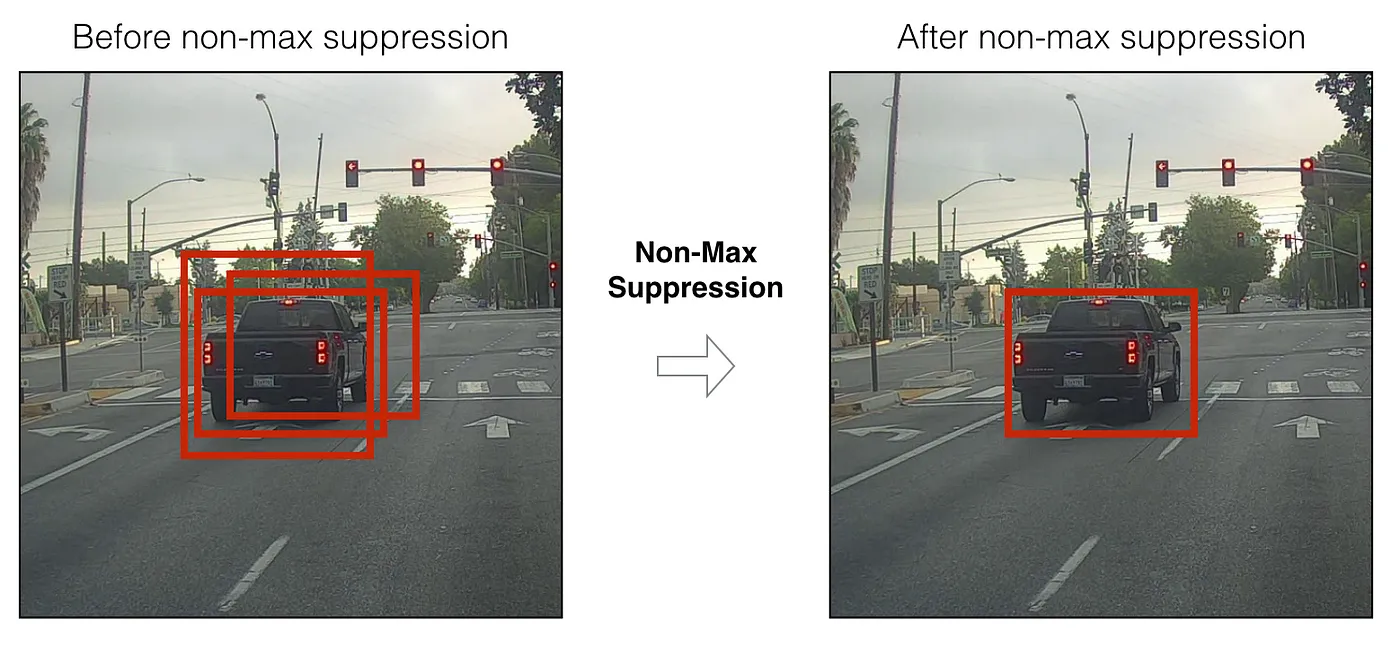

# Testing our Model

Now lets take an image from the test set and try to predict on it

In [ ]:
dataset_test = ConeImagesDataset(test_dir, image_size, image_size, transforms=get_transform(train=False))

# pick one image from the test set
img, target = dataset_test[114]
# put the model in evaluation mode
loaded_model.eval()
with torch.no_grad():
  prediction = loaded_model([img.to(device)])[0]

nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction)

In [ ]:
img.shape

Evaluate on full test set, and view results as a video

In [ ]:
# evaluate on test set, storing result images
!mkdir -p results
for count, (img, _) in enumerate(dataset_test):
  with torch.no_grad():
    prediction = model([img.to(device)])[0]
    nms_prediction = apply_nms(prediction, iou_thresh=0.01)
    plot_img_bbox(torch_to_pil(img), nms_prediction, save_filename="results/file%02d.png"%count)

# convert images into a video
!ffmpeg -framerate 4 -i results/file%02d.png -r 30 -pix_fmt yuv420p -y result.mp4

# display video
from IPython.display import HTML
from base64 import b64encode
mp4 = open('result.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
torch.save(model.state_dict(), './cone-detector.pt')

In [ ]:
loaded_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
in_features = loaded_model.roi_heads.box_predictor.cls_score.in_features
loaded_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 6)
loaded_model.load_state_dict(torch.load('./cone-detector.pt'))
loaded_model.to(device)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp ./cone-detector.pt /content/drive/MyDrive/racing-ai/

In [ ]:
!gdown https://drive.google.com/uc?id=1sZ4trPhKUw1mUSZPbE7whcaI-97r8hdA